# Modèle SVM pour détecter les risques de cancer cervical
par Binh Minh TRAN

## 1. Télechargement des packages nécessaires

In [1]:
# 1. Manipulation des données
import numpy as np
import pandas as pd

# 2. Sérialisation des objets Python
import pickle

# 3. Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Prétraitement des données
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 5. Modélisation
from sklearn import svm
from sklearn.svm import SVC

# 6. Évaluation du modèle (Model Evaluation)
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# 7. Validation croisée et recherche de paramètres
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit

# 8. Traitement des étiquettes
from sklearn.preprocessing import label_binarize

# 9. Outils supplémentaires
from collections import Counter

# 10. Fonctions personnalisées
from fonctionUtile import * 

## 2. Importation des ensembles d'entraînement et de test (validation croisée)

In [2]:
with open('variables.pkl', 'rb') as f:
    (fold_indices, df, X_train, X_test, y_train, y_test,
                 X_train_1, Y_train_1, X_train_2, Y_train_2, 
                 X_train_3, Y_train_3, X_train_4, Y_train_4, 
                 X_train_5, Y_train_5,  
                 X_test_1, Y_test_1, X_test_2, Y_test_2, 
                 X_test_3, Y_test_3, X_test_4, Y_test_4,
                 X_test_5, Y_test_5, ) = pickle.load(f)

In [3]:
list_X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]
list_Y_train = [Y_train_1, Y_train_2, Y_train_3, Y_train_4, Y_train_5]
list_X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]
list_Y_test = [Y_test_1, Y_test_2, Y_test_3, Y_test_4, Y_test_5]

## 3. Vérification de la séparation linéaire avec SVM

Avec 19 attributs, on ne peut pas visualiser, donc on effectue une PCA pour projeter l'ensemble d'entraînement dans un espace à 2 dimensions et effectuer un SVM avec un noyau linéaire. On applique la PCA pour déterminer si nous devons utiliser un noyau non linéaire pour le SVM.

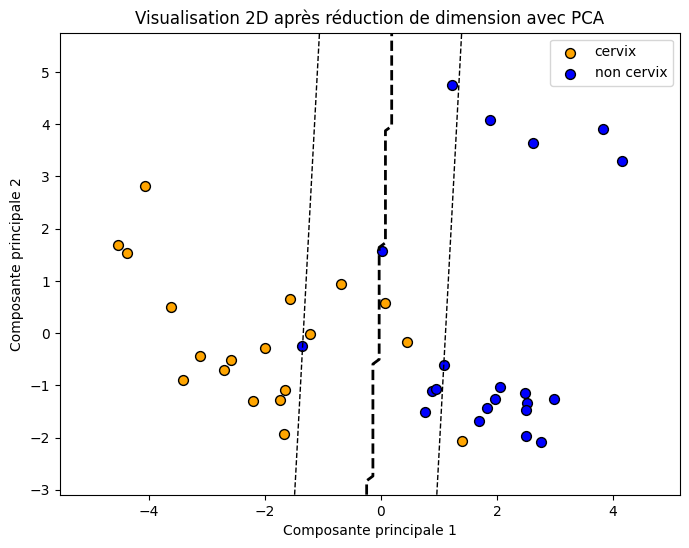

In [4]:
pca_et_visualisation(X_train_1, Y_train_1)

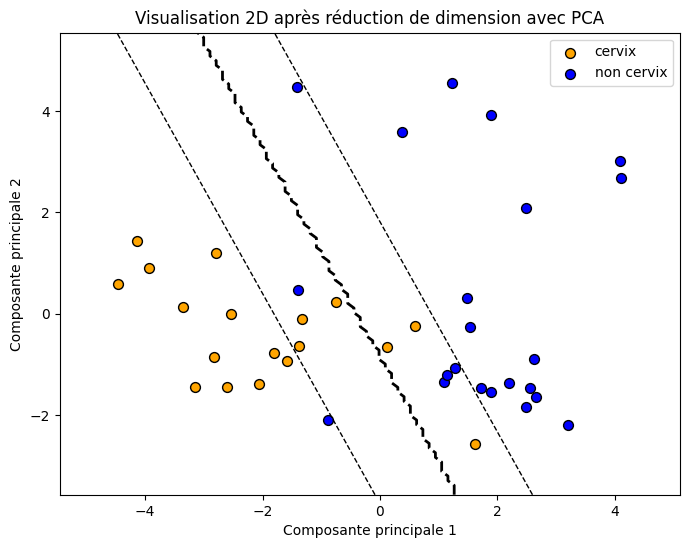

In [5]:
pca_et_visualisation(X_train_2, Y_train_2)

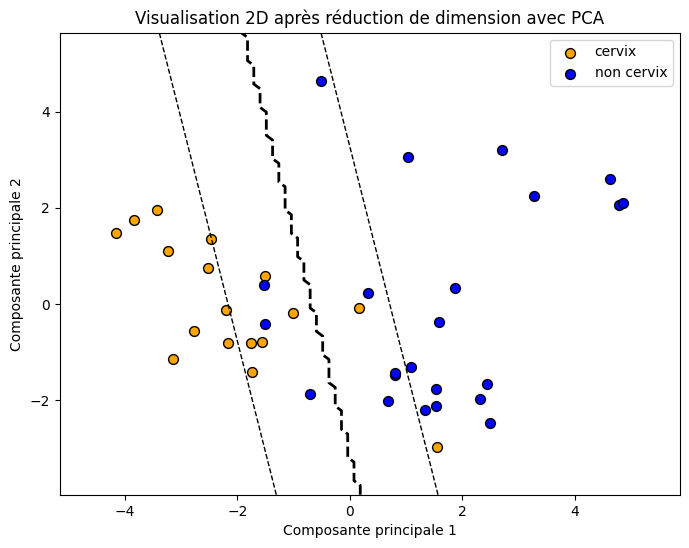

In [6]:
pca_et_visualisation(X_train_3, Y_train_3)

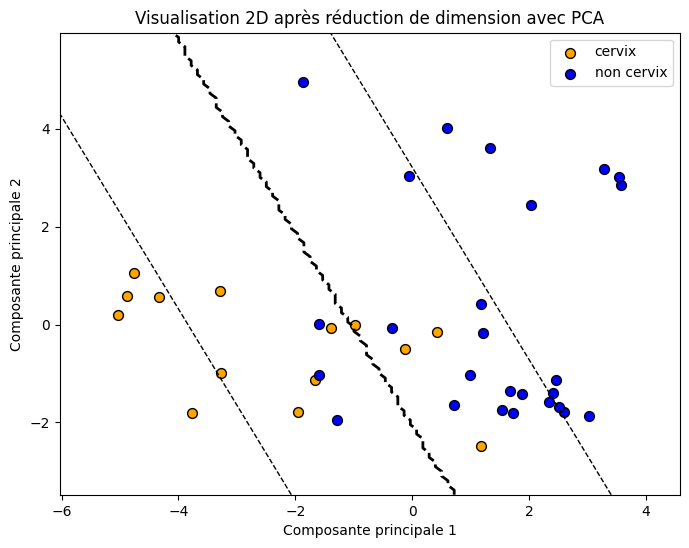

In [7]:
pca_et_visualisation(X_train_4, Y_train_4)

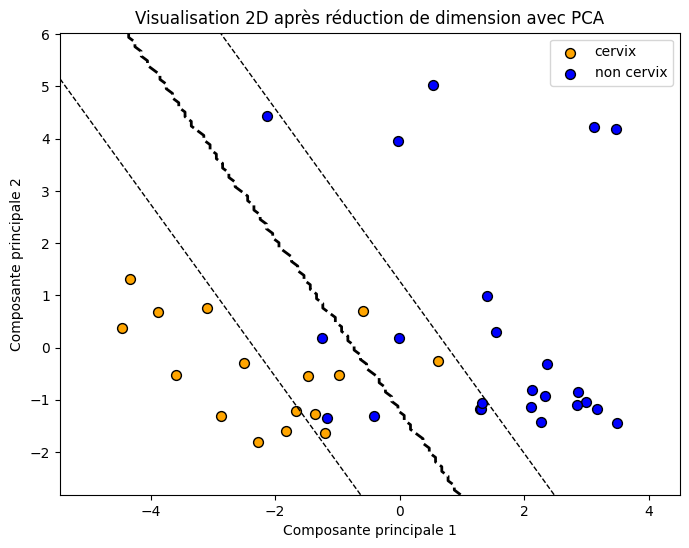

In [8]:
pca_et_visualisation(X_train_5, Y_train_5)

On peut évidemment observer la séparation linéaire dans les 5 ensembles d'entraînement, mais elle n'est pas clairement définie. Cependant, nous allons tout de même essayer d'entraîner le modèle avec un noyau linéaire.

## 4. SVM

### 4.1 Optimisation des hyperparamètres de SVM avec Cross-Validation

In [9]:
scores = []
f1_scores = []
best_C_values = []

X_tr, X_t = X_train, X_test
y_tr, y_t = y_train, y_test 

scaler = StandardScaler()  # Initialisation du standardiseur
X_train_scaled = scaler.fit_transform(X_tr)  # Normalisation des données d'entraînement
X_test_scaled = scaler.transform(X_t)  # Normalisation des données de test

svc = SVC(kernel='linear')  #noyau linear

C_range = np.logspace(-2, 10, 13)  # Créer 13 valeurs de C entre 10^-2 et 10^10 
param_grid = {'C': C_range}  # Paramètres (seulement C ici)

cv = KFold(n_splits=5, shuffle=True,random_state = 18)

# Recherche des meilleurs paramètres avec GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1) 
grid_search.fit(X_train_scaled, y_tr)  

best_C = grid_search.best_params_['C']  # Meilleure valeur de C trouvée
best_model = grid_search.best_estimator_  # Meilleur modèle trouvé
best_C_values.append(best_C)  # Stocker la meilleure valeur de C pour chaque pli

y_pred = best_model.predict(X_test_scaled)  # Prédiction des classes sur les données de test

score = accuracy_score(y_t, y_pred)  # Calcul de la  (accuracy)
f1 = f1_score(y_t, y_pred)  # Calcul du F1-score

scores.append(score) 
f1_scores.append(f1) 


print("\nPrécision moyenne sur tous les plis:", np.mean(scores))  
print("F1-score moyen sur tous les plis:", np.mean(f1_scores))  
print("Meilleures valeurs de C pour chaque pli:", best_C_values)  


Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [0.1]


In [10]:
y_pred_train = grid_search.predict(X_train_scaled)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Train F1:", f1_score(y_train, y_pred_train))

Train Accuracy: 0.96
Train F1: 0.9166666666666666


In [11]:
print("Best parameters:", grid_search.best_params_)

print("Best score:", grid_search.best_score_)

cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['param_C', 'mean_test_score']])

Best parameters: {'C': 0.1}
Best score: 0.8400000000000001
         param_C  mean_test_score
0   1.000000e-02             0.74
1   1.000000e-01             0.84
2   1.000000e+00             0.84
3   1.000000e+01             0.84
4   1.000000e+02             0.84
5   1.000000e+03             0.84
6   1.000000e+04             0.84
7   1.000000e+05             0.84
8   1.000000e+06             0.84
9   1.000000e+07             0.84
10  1.000000e+08             0.84
11  1.000000e+09             0.84
12  1.000000e+10             0.84


Après l'entraînement sur 5 plis, nous pouvons choisir C = 0.01 comme les meilleures valeurs de C pour le modèle final avec noyau lineaire


In [12]:
scores = []
f1_scores = []
best_C_values_rbf = []

X_tr, X_t = X_train, X_test
y_tr, y_t = y_train, y_test 

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_tr)  # Normalisation des données d'entraînement
X_test_scaled = scaler.transform(X_t)  # Normalisation des données de test

    
svc = SVC(kernel='rbf')  #  noyau RBF
    
C_range = np.logspace(-2, 10, 13)  # Créer 13 valeurs de C entre 10^-2 et 10^10 
param_grid = {'C': C_range}  # Paramètres de recherche (seulement C ici)
    
cv = KFold(n_splits=5, shuffle=True,random_state = 18)
    
# Recherche des meilleurs paramètres avec GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', n_jobs=-1) 
grid_search.fit(X_train_scaled, y_tr)  
    
best_C = grid_search.best_params_['C']  
best_model = grid_search.best_estimator_  
best_C_values_rbf.append(best_C)  
    
y_pred = best_model.predict(X_test_scaled)  # Prédiction des classes sur les données de test
    
score = accuracy_score(y_t, y_pred)  # Calcul de la  (accuracy)
f1 = f1_score(y_t, y_pred)  # Calcul du F1-score
    
scores.append(score)  # Ajouter la précision pour ce pli
f1_scores.append(f1)  # Ajouter le F1-score pour ce pli
    
print("\nPrécision moyenne sur tous les plis:", np.mean(scores))  
print("F1-score moyen sur tous les plis:", np.mean(f1_scores))  
print("Meilleures valeurs de C pour chaque pli:", best_C_values_rbf)  


Précision moyenne sur tous les plis: 1.0
F1-score moyen sur tous les plis: 1.0
Meilleures valeurs de C pour chaque pli: [10.0]


In [13]:
print("Best parameters:", grid_search.best_params_)

print("Best score:", grid_search.best_score_)

cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['param_C', 'mean_test_score']])

Best parameters: {'C': 10.0}
Best score: 0.8000000000000002
         param_C  mean_test_score
0   1.000000e-02             0.74
1   1.000000e-01             0.74
2   1.000000e+00             0.78
3   1.000000e+01             0.80
4   1.000000e+02             0.80
5   1.000000e+03             0.80
6   1.000000e+04             0.80
7   1.000000e+05             0.80
8   1.000000e+06             0.80
9   1.000000e+07             0.80
10  1.000000e+08             0.80
11  1.000000e+09             0.80
12  1.000000e+10             0.80


In [14]:
y_pred_train = grid_search.predict(X_train_scaled)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Train F1:", f1_score(y_train, y_pred_train))

Train Accuracy: 1.0
Train F1: 1.0


Nous pouvons choisir C = 1 comme la meilleure valeur de C pour le modèle final avec noyau RBF.

### 4.2 Entraînement du modèle avec le meilleur paramètre C

Après avoir trouvé la valeur optimale de C lors de la validation croisée, nous utilisons l'ensemble d'entraînement déjà divisé (avec un ratio de 70/30 -random_state = 42 dans le fichier Preparation.ipynb) pour réentraîner le modèle avec la meilleure valeur de C trouvée.

In [15]:
print(X_train.shape)
print(X_test.shape)

(50, 19)
(22, 19)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [17]:
svc_best_rbf = SVC(C=10, kernel='rbf', probability=True)

svc_best_rbf.fit(X_train_scaled, y_train)

y_pred_rbf = svc_best_rbf.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_rbf)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_rbf))

Confusion Matrix:
[[14  0]
 [ 0  8]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



Avec ces résultats, on peut dire que lorsque C augmente, le classificateur SVM tend à classer les données de manière de plus en plus précise et nette. Cependant, dans le cadre du SVM, il existe un concept appelé 'soft margins', qui signifie accepter qu'un certain nombre de points soient mal classés. Cela permet d'améliorer la généralisation du modèle.

In [18]:
y_pred_train = svc_best_rbf.predict(X_train_scaled)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Train F1:", f1_score(y_train, y_pred_train))

Train Accuracy: 1.0
Train F1: 1.0


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [20]:
svc_best_lin = SVC(C=1, kernel='linear', probability=True)

svc_best_lin.fit(X_train_scaled, y_train)
y_pred_lin = svc_best_lin.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_lin)

print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_lin))

Confusion Matrix:
[[14  0]
 [ 0  8]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         8

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



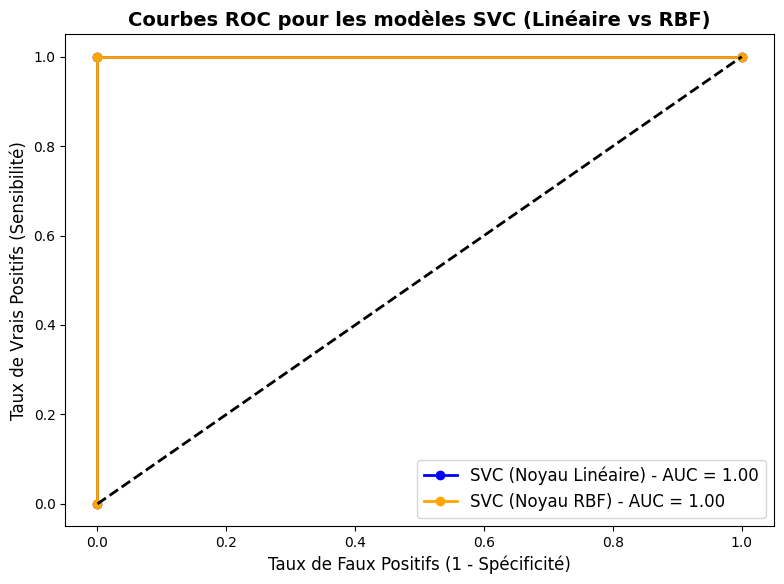

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_lin, tpr_lin, _ = roc_curve(y_test, y_pred_lin)  # ROC pour le modèle SVC avec noyau linéaire
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)  # ROC pour le modèle SVC avec noyau RBF

auc_lin = auc(fpr_lin, tpr_lin)  # AUC pour le modèle SVC avec noyau linéaire
auc_rbf = auc(fpr_rbf, tpr_rbf)  # AUC pour le modèle SVC avec noyau RBF

plt.figure(figsize=(8, 6))

plt.plot(fpr_lin, tpr_lin, label=f'SVC (Noyau Linéaire) - AUC = {auc_lin:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='blue', color='blue')
plt.plot(fpr_rbf, tpr_rbf, label=f'SVC (Noyau RBF) - AUC = {auc_rbf:.2f}', linewidth=2, marker='o', markersize=6, markerfacecolor='orange', color='orange')

# Tracer la ligne diagonale (modèle aléatoire avec AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

plt.rcParams['font.size'] = 12
plt.title('Courbes ROC pour les modèles SVC (Linéaire vs RBF)', fontsize=14, fontweight='bold')

plt.xlabel('Taux de Faux Positifs (1 - Spécificité)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=12)

plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/ROC_SVM.png")
plt.show()

#### Critique 

Nous pouvons conclure qu'avec cet ensemble de données, le modèle SVM avec noyau RBF donne de meilleurs résultats en termes de précision (accuracy), F1-score, courbe ROC, et AUC = 0.92. Nous allons utiliser ce modèle avec noyau RBF pour le comparer avec d'autres modèles tels que Naive Bayes, Decision Tree, ou Logistic Regression.

## 5. Exporter les variables

In [22]:
roc_data_rbf = {
    'fpr_rbf': fpr_rbf,
    'tpr_rbf': tpr_rbf,
    'auc_rbf': auc_rbf
}

with open('roc_data_rbf.pkl', 'wb') as file:
    pickle.dump(roc_data_rbf, file)
print("Les données ont été enregistrées avec succès dans 'variables.pkl'.")

Les données ont été enregistrées avec succès dans 'variables.pkl'.
